# Exploring Dandiset 000617: Allen Institute Openscope - Sequence Learning Project

*This notebook was generated with the assistance of AI. Please verify code, outputs, and interpretations before using for scientific conclusions.*

---

## Overview

This notebook introduces **Dandiset 000617**, the *Allen Institute Openscope - Sequence Learning Project*. This dataset provides two-photon calcium imaging, behavioral, and stimulus data recorded from mouse neocortex during a sequence learning experiment. It enables detailed analyses of predictive coding, neuronal population dynamics, and behavior in response to visual stimuli.

- **Dandiset full record:** [https://dandiarchive.org/dandiset/000617/0.250311.1615](https://dandiarchive.org/dandiset/000617/0.250311.1615)

### What the notebook covers
- Dandiset overview and metadata summary
- Loading asset information via the DANDI API
- Streaming NWB files remotely
- Visualizing two-photon imaging traces, running speed, and stimulus intervals for an example session
- Annotated code and explanations to guide new users

---
## Requirements
- `dandi`
- `remfile`
- `h5py`
- `pynwb`
- `numpy`
- `pandas`
- `matplotlib`

(All packages are assumed to be installed.)

Let's get started!

## 1. Explore Dandiset Assets

We begin by using the DANDI API to list files available in Dandiset 000617. This will help us select a file for further exploration.

In [1]:
from dandi.dandiapi import DandiAPIClient

# Connect to the DANDI Archive and get information about Dandiset 000617, version 0.250311.1615
dandiset_id = "000617"
dandiset_version = "0.250311.1615"

with DandiAPIClient() as client:
    dandiset = client.get_dandiset(dandiset_id, dandiset_version)
    # List a few NWB files in the dandiset
    assets = list(dandiset.get_assets())
    print(f"Number of assets found: {len(assets)}")
    print("First 5 assets:")
    for asset in assets[:5]:
        print(asset.path)

Number of assets found: 1197
First 5 assets:
sub-684475/sub-684475_ses-1294084428-acq-1294179945-raw-movies_ophys.nwb
sub-684475/sub-684475_ses-1294084428-acq-1294179943-raw-movies_ophys.nwb
sub-684475/sub-684475_ses-1293785946-acq-1293914859-raw-movies_ophys.nwb
sub-684475/sub-684475_ses-1294084428-acq-1294179942-raw-movies_ophys.nwb
sub-684475/sub-684475_ses-1294259213-acq-1294370666-raw-movies_ophys.nwb


## 2. Select an Example Session

We'll focus on one sample NWB file:  
`sub-684475/sub-684475_ses-1294084428-acq-1294179945-raw-movies_ophys.nwb`

This file contains optical physiology and behavioral data from a single session.

In [2]:
# Find the download URL for the selected asset
selected_asset_path = "sub-684475/sub-684475_ses-1294084428-acq-1294179945-raw-movies_ophys.nwb"

with DandiAPIClient() as client:
    dandiset = client.get_dandiset(dandiset_id, dandiset_version)
    asset = next(dandiset.get_assets_by_glob(selected_asset_path))
    nwb_url = asset.download_url

print("Remote NWB file URL:", nwb_url)

Remote NWB file URL: https://api.dandiarchive.org/api/dandisets/000617/versions/0.250311.1615/assets/3eaf1acf-7a63-4286-a7c0-7a58d8cae2f8/download/


## 3. Load the NWB File Remotely

We'll stream the NWB file data directly from the remote storage using `remfile` and `h5py`, abided by [pynwb]'s streaming functionality.

**Note:** No file will be downloaded locally; all operations are performed via remote streaming.

In [3]:
import remfile
import h5py
import pynwb

# Open the remote file and load it via h5py and pynwb
remote_file = remfile.File(nwb_url)
h5_file = h5py.File(remote_file, "r")
io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
nwb = io.read()

# Print some basic session metadata
print("Session identifier:", nwb.identifier)
print("Session description:", nwb.session_description)
print("Session start time:", nwb.session_start_time)
print("Subject id:", nwb.subject.subject_id)
print("Field of view location:", nwb.imaging_planes["imaging_plane_1"].location)

/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.3.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Session identifier: 1294179945
Session description: Ophys Session
Session start time: 2023-08-31 20:49:56.751000+00:00
Subject id: 684475
Field of view location: VISpm


## 4. Explore Two-Photon Calcium Imaging Data

Let's inspect the processed calcium traces (`dF/F`) for segmented cells during the session.

- Each column corresponds to a region-of-interest (cell).
- Data is provided as a (timepoints × cells) array, with a sample interval of ~0.1s.

dF/F data shape (frames, cells): (40018, 18)
Timestamps shape: (40018,)


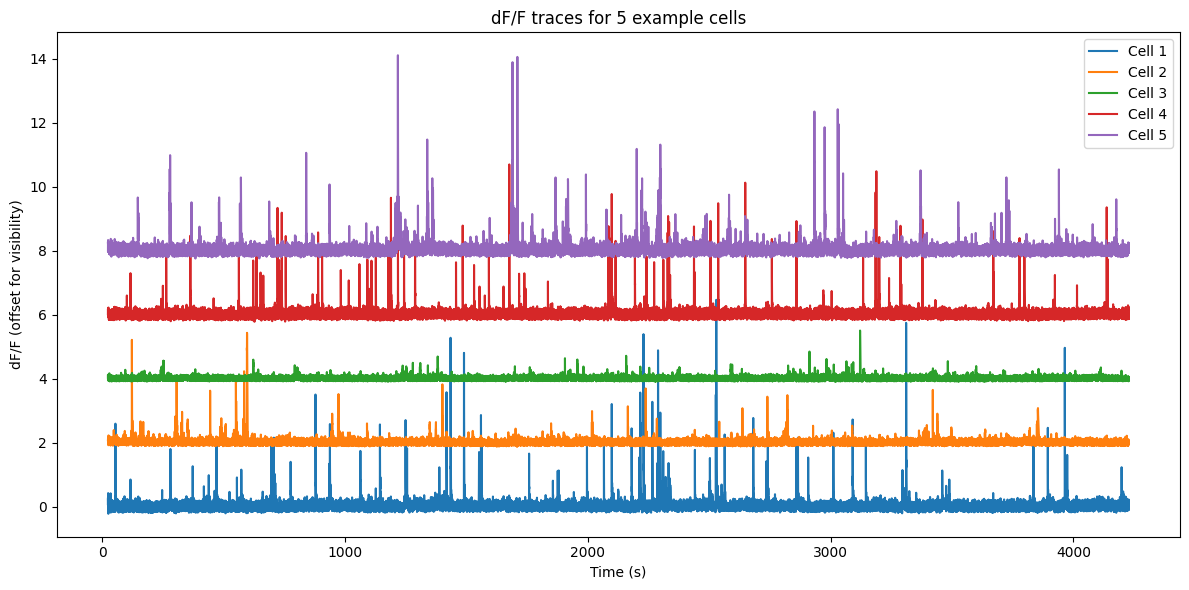

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Access dF/F traces and timestamps
ophys_proc = nwb.processing["ophys"]
dff = ophys_proc.data_interfaces["dff"]
traces = dff.roi_response_series["traces"]

# Retrieve data
dff_data = traces.data[:]
dff_timestamps = traces.timestamps[:]
print("dF/F data shape (frames, cells):", dff_data.shape)
print("Timestamps shape:", dff_timestamps.shape)

# Plot traces for the first 5 cells
plt.figure(figsize=(12, 6))
for i in range(min(5, dff_data.shape[1])):
    plt.plot(dff_timestamps, dff_data[:, i] + i*2, label=f'Cell {i+1}')
plt.xlabel("Time (s)")
plt.ylabel("dF/F (offset for visibility)")
plt.title("dF/F traces for 5 example cells")
plt.legend()
plt.tight_layout()
plt.show()

## 5. Visualize Running Speed

The processed running speed (cm/s) is stored in the `running` processing module. Let's plot it over time.

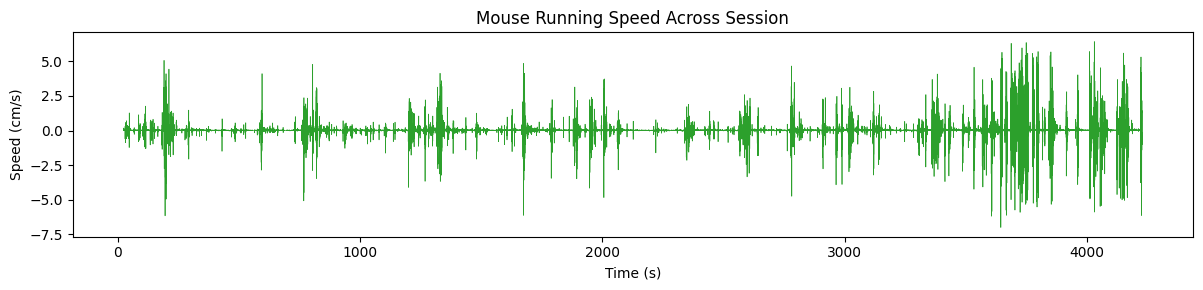

In [5]:
# Access running speed and timestamps
speed_ts = nwb.processing["running"].data_interfaces["speed"]
speed = speed_ts.data[:]
speed_timestamps = speed_ts.timestamps[:]

plt.figure(figsize=(12, 3))
plt.plot(speed_timestamps, speed, color='tab:green', lw=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Speed (cm/s)")
plt.title("Mouse Running Speed Across Session")
plt.tight_layout()
plt.show()

## 6. Examine Presented Stimuli Intervals

Information about stimulus presentations (movies A/B/C and gray screens) is stored in the NWB's `intervals` container.

Let's visualize when each type of movie was shown during the session.

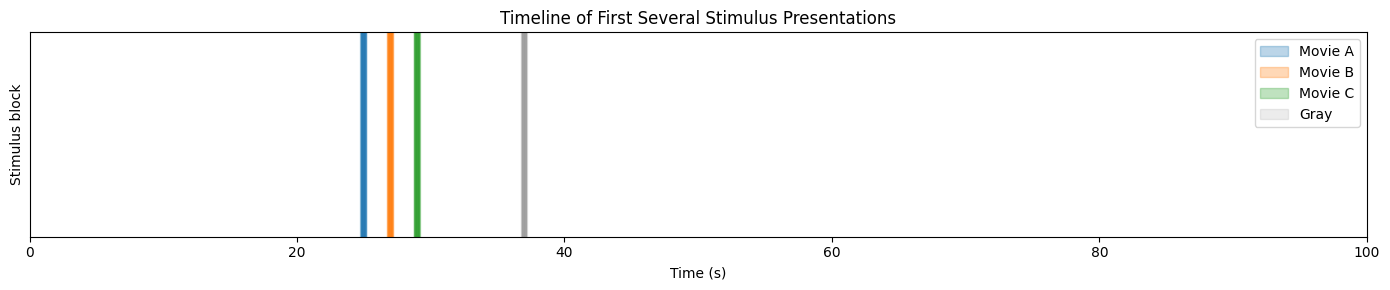

In [6]:
import pandas as pd

intervals = nwb.intervals

# Get dataframe for each stimulus type (example: movie_clip_A, movie_clip_B, movie_clip_C, gray)
movie_A_df = intervals["movie_clip_A_presentations"].to_dataframe()
movie_B_df = intervals["movie_clip_B_presentations"].to_dataframe()
movie_C_df = intervals["movie_clip_C_presentations"].to_dataframe()
gray_df    = intervals["gray_presentations"].to_dataframe()

plt.figure(figsize=(14, 3))
for onset, offset in zip(movie_A_df['start_time'].values[:25], movie_A_df['stop_time'].values[:25]):
    plt.axvspan(onset, offset, color='tab:blue', alpha=0.3, label='Movie A' if onset == movie_A_df['start_time'].values[0] else "")
for onset, offset in zip(movie_B_df['start_time'].values[:25], movie_B_df['stop_time'].values[:25]):
    plt.axvspan(onset, offset, color='tab:orange', alpha=0.3, label='Movie B' if onset == movie_B_df['start_time'].values[0] else "")
for onset, offset in zip(movie_C_df['start_time'].values[:25], movie_C_df['stop_time'].values[:25]):
    plt.axvspan(onset, offset, color='tab:green', alpha=0.3, label='Movie C' if onset == movie_C_df['start_time'].values[0] else "")
for onset, offset in zip(gray_df['start_time'].values[:25], gray_df['stop_time'].values[:25]):
    plt.axvspan(onset, offset, color='gray',        alpha=0.15, label='Gray' if onset == gray_df['start_time'].values[0] else "")

plt.xlabel("Time (s)")
plt.ylabel("Stimulus block")
plt.yticks([])
plt.xlim(0, 100)  # Show the first 100 seconds for clarity
plt.legend(loc="upper right")
plt.title("Timeline of First Several Stimulus Presentations")
plt.tight_layout()
plt.show()

## 7. Summary & Next Steps

In this notebook, we:
- Explored Dandiset 000617 and inspected its metadata
- Loaded session data remotely using the DANDI API, remfile, h5py, and pynwb
- Visualized key components: calcium imaging (dF/F), running speed, and stimulus interval structure

**You can extend this framework to:**
- Compare activity across stimulus conditions or sessions
- Analyze event detections or single-cell response properties
- Co-register activity with running or eye-tracking signals

For more information, see the [Dandiset landing page](https://dandiarchive.org/dandiset/000617/0.250311.1615) and the Allen Brain Observatory documentation.

---

*Remember: This notebook was generated with AI assistance. Always validate code and results in your own workflow!*